# Calculate recovery indicators over Santa Rem

*This script calculates a set of recovery indicators from satellite time series, including the RRI, R80P and YrYr recovery indicators, defined by Frazier et al. (2018), and the post-disturbance slope. These indicators can be derived from dense (having more than one observation per year) time series or the dense time series can be converted to annual time series. In addition, the indicators can be calculated using the raw time series, smoothed time series or after trend segmentation.*

*The RRI, R80p and YrYr recovery indicators are originally developped for annual long-term time series of optical vegetation indices. Yet, in order to be able to derive the indicators as well for dense and/or short time series, a modified version is suggested. Here, the user can define the time period before, during and after the disturbance that is used to derive the indicators. To reduce the interference of the seasonal pattern of dense time series, the chosen time period should cover blocks of n years. Moreover, given the potentially high noise levels of dense time series, the mean value instead of the maximum value was used in the formulas.*

*In addition to the recovery indicators defined by Frazier et al. (2018), the slope of the post-disturbance trend segment can be derived as recovery indicator. The latter indicator is only available for trend segmented time series: a segmented trend is fitted in the time series, and the detected break showing the largest change (in absolute values) is assumed to represent the disturbance. The slope of the trend segment after the disturbance is then used as recovery indicator.*

## Import packages

In [1]:
#install.packages('signal')
library(signal)
#install.packages('imputeTS')
library(imputeTS)


Attaching package: 'signal'

The following objects are masked from 'package:stats':

    filter, poly

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


## Inputs


In [2]:
ifolder <- 'C:\\Users\\keers001\\OneDrive\ -\ WageningenUR\\RETURN\\Data\\RETURN\\20191019_SimulationOptSAR\\Case_SantaRem\\' # folder with data characteristics
ofolder <- 'C:\\Users\\keers001\\OneDrive\ -\ WageningenUR\\RETURN\\Data\\RETURN\\20191019_SimulationOptSAR\\Case_SantaRem\\' # folder where the simulated time series will be saved
nfolder <- 'C:\\Users\\keers001\\Dropbox\\output\\Jupyter_notebook\\Functions\\'

tsfile <- 'LSTS_LSTS_FireArea_SantaRem_smp_40000_VI'
fireDatefile <- 'LSTS_LSTS_FireArea_SantaRem_smp_40000_fireDate.rda'

funSet <- list('freq' = c('annual', 'dense','dense','dense','dense','dense','dense'),
              'input' = c('raw', 'raw', 'smooth', 'BFAST', 'raw', 'smooth', 'BFAST'),# settings for the recovery indicators
              'shortDenseTS' = c(FALSE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE),
              'nPre' = c(2,2,2,2,2,2,2),
              'nDist' = c(1,1,1,1,12,12,12),
              'nPostMin' = c(0,0,0,0,4,4,4),
              'nPostMax' = c(1,1,1,1,6,6,6),
              'h' = c(0.15,0.15,0.15,0.15,0.15,0.15,0.15))

## Extract recovery indicators

In [3]:
system(paste0('jupyter-nbconvert.exe ', nfolder, 'rec_Functions.ipynb  --to script'))#, intern=FALSE
source(file.path(nfolder, 'rec_Functions.r'))

# time series to be processed
tsi <- loadRData(paste0(ifolder,tsfile,'.rda'))
# fire dates
firei <- loadRData(paste0(ifolder,fireDatefile))





[1] 0

Loading required package: zoo

Attaching package: 'zoo'

The following object is masked from 'package:imputeTS':

    na.locf

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich


## Select pixels that show a large drop in NBR

[1] 573

ERROR: Error in firei[which(drop < -0.2), ]: incorrect number of dimensions


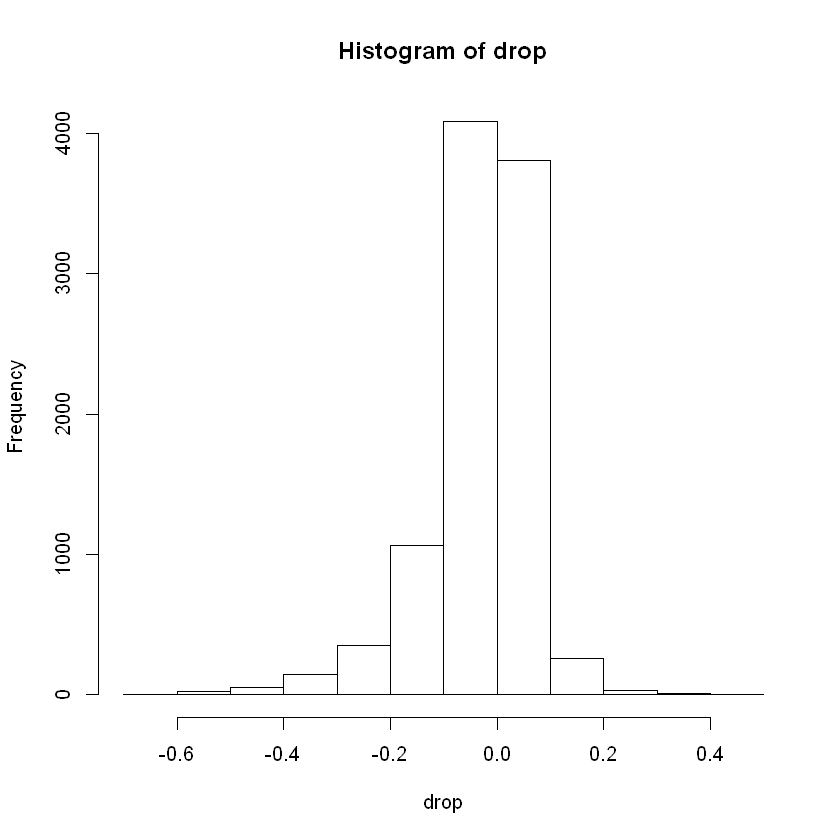

In [11]:
drop <- rep(NA,dim(tsi)[1]) 
for(i in 1:length(drop)){
    tdist <- as.numeric(1+ as.Date(firei[[i]][[3]]) - as.Date('2000-01-01'))# timing disturbance
    if(tdist>730){
        tsii <- tsi[i,-c(1,2)]
        preDist <- mean(as.numeric(tsii[(tdist-730):(tdist-1)]), na.rm=T)
        postDist <- mean(as.numeric(tsii[tdist:(tdist+365)]), na.rm=T)
        drop[i] <- postDist-preDist
    }
}
hist(drop)
length(which(drop < -0.2))
tsi <- tsi[which(drop < -0.2),]
firei <- firei[which(drop < -0.2)]

[1] 10000  7307

[1] 20.01918

[1] 0

[1]    1 7305

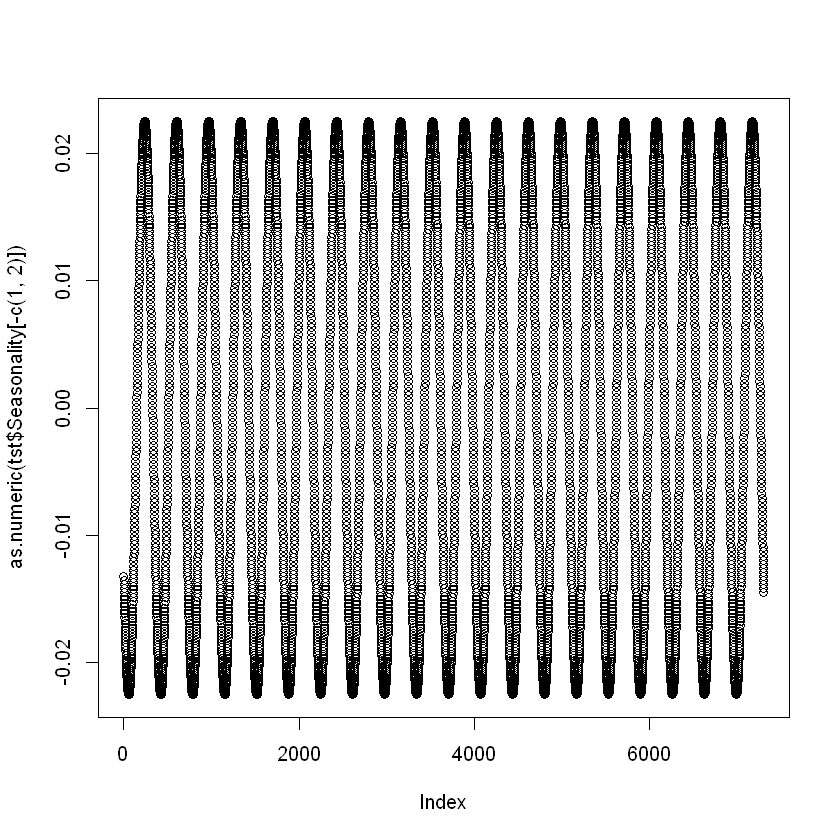

In [4]:
dim(tsi)
7307/365
#names(tsi)

system(paste0('jupyter-nbconvert.exe ', nfolder, 'sim_Functions.ipynb  --to script'))#, intern=FALSE
source(file.path(nfolder, 'sim_Functions.r'))
tst <- decompTSbfast(tsi[1,], 20, 365)
dim(tst$Seasonality[-c(1,2)])
plot(as.numeric(tst$Seasonality[-c(1,2)]))

In [15]:
m_RRIi <- matrix(NA, nrow = length(funSet[[1]]), ncol = (dim(tsi)[1]))# measured RRI 
m_R80pi <- matrix(NA, nrow = length(funSet[[1]]), ncol = (dim(tsi)[1]))# measured R80p 
m_YrYri <- matrix(NA, nrow = length(funSet[[1]]), ncol = (dim(tsi)[1]))# measured YrYR
m_SLi <- matrix(NA, nrow = length(funSet[[1]]), ncol = (dim(tsi)[1]))# measured YrYR   
    
for (rset in 2:length(funSet[[1]])){# iterate over recovery settings
    for (i in 1:dim(tsi)[1]){# iterate over time series
        
       tsii <- as.numeric(tsi[i,-c(1,2)])
       tdist <- as.numeric(1+ as.Date(firei[[i]][[3]]) - as.Date('2000-01-01'))# timing disturbance
       obspyr <- 365
             
       inp <- funSet$input[rset]
       frq <- funSet[['freq']][rset]
       shortDenseTS <- funSet[['shortDenseTS']][rset]
       nPre <- funSet[['nPre']][rset]
       nDist <- funSet[['nDist']][rset]
       nPostMin <- funSet[['nPostMin']][rset]
       nPostMax <- funSet[['nPostMax']][rset]
       h <- funSet[['h']][rset]
       
       if (frq == 'annual'){
           #convert time series to annual values by selecting date closest to seasonal max
           tsii <- toAnnualTS(tsseas, tsii, obspyr) 
           tdist <- ceiling(tdist/obspyr)
           obspyr <- 1
       }
       if (inp == 'smooth'){
           tmp <- sgolayfilt(na_interpolation(tsii, 'linear'), p=2, n=11)# smooth time series using golay filter
           tsii[is.na(tsii)==F] <- tmp[is.na(tsii)==F]
       }
           
       if((inp == 'smooth') | (inp == 'raw')){ 
           outp <- calcFrazier(tsii, tdist, obspyr, shortDenseTS, nPre, nDist, nPostMin, nPostMax)
           m_RRIi[rset,i] <- outp$RRI# measured RRI 
           m_R80pi[rset,i] <- outp$R80P# measured R80p 
           m_YrYri[rset,i] <- outp$YrYr# measured YrYR
           rm(outp)
       }
       if(funSet$input[rset] == 'BFAST'){ 
           outp <- calcBFASTrec(tsii, obspyr, h, shortDenseTS, nPre, nDist, nPostMin, nPostMax)
           m_RRIi[rset,i] <- outp$RRI# measured RRI 
           m_R80pi[rset,i] <- outp$R80P# measured R80p 
           m_YrYri[rset,i] <- outp$YrYr# measured YrYR
           m_SLi[rset,i] <- outp$Sl# measured YrYR
           #print(outp)
           rm(outp)
       }
           
       #save temporary results
        save(m_RRIi, file = paste0(ofolder,tsfile,'_RRI_',rset,'_02.rda'))# measured RRI 
        save(m_R80pi, file = paste0(ofolder,tsfile,'_R80p_',rset,'_02.rda'))# measured R80p 
        save(m_YrYri, file = paste0(ofolder,tsfile,'_YrYr_',rset,'_02.rda'))# measured YrYR
        save(m_SLi, file = paste0(ofolder,tsfile,'_SL_',rset,'_02.rda'))# measured slope


   }
}
 
crds <- tsi[,c(1,2)]
save(crds, file = paste0(ofolder,tsfile,'_crds_02.rda'))# measured RRI        

In [20]:
crds <- tsi[,c(1,2)]
save(crds, file = paste0(ofolder,tsfile,'_crds_02.rda'))# measured RRI 

## Export as shapefile

In [16]:
library(sp)
library(raster)
crds <- tsi[,c(1,2)]

# RRI
dat <-  as.data.frame(cbind(crds, t(m_RRIi)))
coordinates(dat)= ~lon + lat
proj4string(dat)<- CRS("+proj=longlat +datum=WGS84")
shapefile(dat,paste0(ofolder, tsfile, '_RRI_02'),overwrite=T)
rm(dat)

# R80p
dat <-  as.data.frame(cbind(crds, t(m_R80pi)))
coordinates(dat)= ~lon + lat
proj4string(dat)<- CRS("+proj=longlat +datum=WGS84")
shapefile(dat,paste0(ofolder, tsfile, '_R80p_02'),overwrite=T)
rm(dat)

# YrYr
dat <-  as.data.frame(cbind(crds, t(m_YrYri)))
coordinates(dat)= ~lon + lat
proj4string(dat)<- CRS("+proj=longlat +datum=WGS84")
shapefile(dat,paste0(ofolder, tsfile, '_YrYr_02'),overwrite=T)
rm(dat)

# SL
dat <-  as.data.frame(cbind(crds, t(m_SLi)))
coordinates(dat)= ~lon + lat
proj4string(dat)<- CRS("+proj=longlat +datum=WGS84")
shapefile(dat,paste0(ofolder, tsfile, '_SL_02'),overwrite=T)
rm(dat)




Attaching package: 'raster'

The following object is masked from 'package:signal':

    resample



In [9]:
print(m_RRIi[2,])

    [1]           NaN  1.800259e-01           NaN           NaN           NaN
    [6]           NaN  4.333927e-01           NaN           NaN           NaN
   [11]           NaN  1.092057e+00  8.153255e-01  1.633500e+00  6.547968e+00
   [16]  1.109166e+00           NaN  9.644359e-01  5.093075e-01  6.531940e-01
   [21]  6.605198e-02  9.101425e-01  4.279486e-01 -3.411377e-01  3.281061e+00
   [26]  1.476180e+00  6.255388e-01  2.873226e-01  1.539848e+00  4.608861e-01
   [31]  5.203789e-01  2.165271e+00  3.938776e-01 -2.416169e+01  9.024192e-01
   [36]  2.558474e+00  3.914887e-01 -8.031865e-02  8.766724e-01 -2.383384e+01
   [41]  2.688978e-02  7.392333e-01 -6.535659e+00  1.671332e+00 -7.283400e+00
   [46]  1.511347e+01  2.738284e-01  9.455169e-01           NaN  1.796243e+01
   [51] -5.326249e-03  5.684863e-01  6.692243e-01 -2.651670e+00  1.537104e+01
   [56]  1.816082e+00  9.007299e-01 -2.067189e+00  8.129936e-01 -1.962171e+01
   [61]  9.158489e-01  2.539805e+00  8.451740e-01  2.320493e+00 